# Continuous Normalizing Flows
Normalizing Flows have emerged as a central area of research in generative image modeling. 
Normalizing flows aim to learn an invertible transformation that pushes a simple distribution, such as a standard Gaussian, into a complex data distribution. 
Unlike other generative models, Normalizing Flows provide an exact and tractable way to compute the likelihood, which involves computing the Jacobian determinant.
We focus on a class of normalizing flows coined Continuous Normalizing Flows (CNF). 
Here the invertible transformation is given by the solution of an ordinary differential equation:
$$    \begin{cases}
        \partial_t\phi_t(x_0) = v_t(\phi_t(x_0)) \\
        \phi_0(x_0) = x_0
    \end{cases}. $$
More precisely, by a Neural Ordinary Differential Equation (NODE), where the evolution of the invertible transformation over time is governed by a parameterized vector field.  
In contrast to other approaches, one does not need to specify the number of layers, as the invertible transformation is defined continuously over time. 
Furthermore, this architecture allows to express the Jacobian determinant as the integral of the trace of the Jacobian of the vector field over time:
$$\log\det \nabla_x \phi_t(x) = \int_0^1 \text{div } v_t(\phi_t(x))\, d x,$$
which can be computed by calling an ODE-solver.
Still, computing the Jacobian determinant remains computationally expensive, even when using stochastic approximations as the Hutchinson trace estimator:
$$
\text{div } v_t(\phi_t(x)) = \mathbb{E}_{\epsilon\sim \mathcal N(0,I)} \left [ \epsilon^T\nabla_{\phi_t} v_t(\phi_t(x)) \epsilon \right ]
$$
On top of that, allowing adaptive numerical ODE solvers to refine its step size to very small values results in dynamics equivalent to hundreds or even thousands of layers. 
This highlights the need for regularized dynamics to improve model accuracy with fewer integration steps and reduced training time. 
By encouraging the Neural ODE to prefer simpler, more regular dynamics, the sample trajectories in the Continuous Normalizing Flow become straighter. 
This speeds up both training and sample generation, as straighter paths allow the numerical ODE solver to take larger steps without loosing accuracy. 
In other words, the model learns to transport probability mass along more direct paths from the base distribution to the target distribution, avoiding complex, inefficient transformations. 

In [171]:
#UTILS 
import torch
import torch.optim as optim
import math
import random
import numpy as np
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=None, hidden_dim=256):
        super().__init__()
        if out_dim is None:
            out_dim = in_dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_dim + 1, hidden_dim),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, t, x):
        if t.dim()==0:
            t = t.expand(x.size(0),)
        x = torch.cat((x, t[:,None]),dim=-1) 
        return self.net(x)

#chooses appropriate timesteps for numerical ODE solver
def choose_timesteps(method: str):
    if method in ['euler', 'rk4', 'midpoint', 'explicit_adams', 'implicit_adams']:
        return torch.linspace(0, 1, 5).type(torch.float32)
    
    elif method in ['dopri8', 'dopri5', 'bosh3', 'adaptive_heun']:
        return torch.linspace(0, 1, 2).type(torch.float32)
    
    else:
        raise Exception("numerical method not supported")
    
#prints a progress bar
def progress_bar(i, total, time, est_time):
    progress = (i) / total
    bar_length = 40
    block = int(round(bar_length * progress))
    progress_bar = "#" * block + "-" * (bar_length - block)
    print(f"\rProgress: [{progress_bar}] {int(progress * 100)}%, Time: {format_elapsed_time(time)}<{format_elapsed_time(est_time)}", end="")


def format_elapsed_time(elapsed_seconds):
    hours = int(elapsed_seconds // 3600) 
    minutes = int((elapsed_seconds % 3600) // 60)  
    seconds = int(elapsed_seconds % 60)
    
    formatted_time = f"{hours:02}:{minutes:02}:{seconds:02}"
    return formatted_time

def sample_mix_normal(n, means=[torch.tensor((1.000, 0.000)), torch.tensor((0.707, 0.707)),
        torch.tensor((0.707, -0.707)), torch.tensor((-0.707, 0.707)),
        torch.tensor((-0.707, -0.707)), torch.tensor((-1.000,0.000)),
        torch.tensor((0.000,1.000)), torch.tensor((0.000,-1.000))]):
    
    num_components = len(means)
    component_choices = torch.randint(0, num_components, (n,))

    samples = []
    for i in component_choices:
        mean = means[i]*2

        distribution = torch.distributions.MultivariateNormal(mean, torch.eye(2)*.01)
        sample = distribution.sample()
        samples.append(sample)
    
    return torch.stack(samples)

def sample_moons(n):
    n_out = n // 2
    n_in = n - n_out
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_out))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_out))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_in))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_in)) - .5

    samples = np.vstack([np.append(outer_circ_x, inner_circ_x),
                   np.append(outer_circ_y, inner_circ_y)]).T
    
    samples += np.random.rand(n, 1) * .2
    samples = torch.Tensor(samples)
    
    return samples * 3 - 1


def sample_checkerboard(n):
    centers = [(0.125, 0.125), (0.625, 0.125), 
               (.625, .625), (.125,.625), 
               (.375,.375), (.875,.375), 
               (.375, .875), (.875, .875)]
    samples = []
    for i in range(n):
        point = np.random.uniform(-0.125, 0.125, size=2)
        center = random.choice(centers)
        point += center
        samples.append(point)
    samples = np.array(samples, dtype='float32')

    return torch.tensor(samples)


class sampler():
    def __init__(self, dataset: str, means: list = [torch.tensor((0.000,0.000))]):
        if dataset == "mixnormal":
            self.sampler = lambda n : sample_mix_normal(n, means)
        elif dataset == "moons":
            self.sampler = sample_moons
        elif dataset == "checkerboard":
            self.sampler = sample_checkerboard
        elif dataset == "normal":
            self.sampler = lambda n : torch.randn((n,2))
            self.log_prob = lambda x : -0.5 * math.log(2 * math.pi) - x.pow(2) / 2
        elif dataset == "uniform":
            self.sampler = lambda n : torch.rand((n,2))
            self.log_prob = lambda x : torch.where((x >= 0) & (x <= 1), 0, -np.inf)
        else:
            raise Exception("Selected Dataset not supported. Choose between normal, gaussians, moons, checkerboard or spirals")

    
    def __call__(self, n: int):
        return self.sampler(n)
    
    
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

def plot(model, params, x=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    t = torch.linspace(1, 0, 100).type(torch.float32)
    if x==None:
        x = sampler(params['initial'])(4000)

    model.eval()
    flow = odeint(model, x.to(device), t.to(device), 
                            method="dopri5",        
                            atol=1e-3,
                            rtol=1e-3,).detach().cpu().numpy()

    cmap = plt.get_cmap('viridis_r')
    norm = Normalize(vmin=0, vmax=1)
    first_color = cmap(norm(0))
    last_color = cmap(norm(1))  

    with torch.no_grad():
        fig, ax = plt.subplots()
        for i in range(4000):
            points = flow[:, i, :2]
            segments = np.array([points[j:j+2] for j in range(len(points)-1)])
            lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=.1, zorder=1, label="flow")
            lc.set_array(t[:-1].numpy())
            ax.add_collection(lc)
        ax.scatter(flow[0, :, 0], flow[0, :, 1], color=last_color, s=.5, label="initial", zorder=0)
        ax.scatter(flow[-1, :, 0], flow[-1, :, 1], color=first_color, s=.5, label="target", zorder=2)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    plt.title(f'{params['method']}')
    plt.show()
    


## Regularized Neural ODE
CNFs align closely with optimal transport theory, where the goal is to find the most efficient way to move mass between distributions. 
In the context of CNFs, learning these straight probability paths can be interpreted as finding the optimal transport path that minimizes the cost of transforming one distribution into another. 
In particular, one can derive two regularization terms from optimal transport theory and fluid dynamics that visibly straighten probability paths. 
A kinetic regularization term penalizing transport cost, i.e. path length
$$
\mathbb{E} \left [ \int_0^1 \|v_t(\phi_t(x)) \|^2 \, d t \right ].
$$ 
And a Jacobian regularization term ensuring training stability
$$
\| \nabla_{\phi_t} v_t(\phi_t(x))\|_F^2.
$$
This approach, termed Regularized Neural ODE (RNODE), encourages well-behaved dynamics, leading to faster and more stable training.
Setting $\phi_0(x_0)=x_0$ and $log\det \nabla_x \phi_t(x_0)=E(0)=n(0)=0$ allows us to compute both terms at no extra cost by solving the following augmented ODE:
$$
\begin{cases}
\partial_t\phi_t(x_0) = v_t(\phi_t(x_0)) \\
\partial_t \log\det \nabla_x \phi_t(x_0) = \mathbb{E}_{\epsilon\sim \mathcal N(0,I)} \left [ \epsilon^T\nabla_{\phi_t} v_t(\phi_t(x_0)) \epsilon \right ] \\
\partial_t E = \|v_t(\phi_t(x_0)) \|^2 \\
\partial_t n =  \| \nabla_{\phi_t} v_t(\phi_t(x_0))\|_F^2                                                                               
\end{cases}
$$


In [172]:
#Computes trace Estimate and Frobenius norm of the Jacobian
def divergence_approx(f, y, e=None):

    samples = []
    sqnorms = []
    for  e_ in e:
        e_dzdx = torch.autograd.grad(f, y, e_, create_graph=True)[0]
        n = e_dzdx.view(y.size(0),-1).pow(2).mean(dim=1, keepdim=True)
        sqnorms.append(n)
        e_dzdx_e = e_dzdx * e_
        samples.append(e_dzdx_e.view(y.shape[0], -1).sum(dim=1, keepdim=True))

    S = torch.cat(samples, dim=1)
    approx_tr_dzdx = S.mean(dim=1)

    N = torch.cat(sqnorms, dim=1).mean(dim=1)


    return approx_tr_dzdx, N

"""regularized Augmented ODE"""
class reg_ode(nn.Module):
    def __init__(self, ode_func: nn.Module):
        super().__init__()
        self.odefunc = ode_func

    def forward(self, t, states):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        z = states[0].to(device)

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)                                         
            dz_dt = self.odefunc(t.to(device), z)
            epsilon = torch.randn_like(z).to(device)
            dlog_det_dt, dn_dt = divergence_approx(dz_dt, z, e=epsilon.unsqueeze(0))
            dE_dt = (torch.linalg.vector_norm(dz_dt, dim=1, keepdims=True)**2)                          #log-det of the Jacobian   

            return (dz_dt, dlog_det_dt.unsqueeze(1), dE_dt, dn_dt.unsqueeze(1))
        
import time
from torchdiffeq import odeint_adjoint as odeint

#likelihood-based method
def node(model, optimizer, initial, target, params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    start = time.time()
    for i in range(1, params['n_batches']+1):
        optimizer.zero_grad()
        
        x = target(params['batch_size']).to(device)
        x.requires_grad = True

        t = choose_timesteps(params['odeint_method']).to(device)
        l0 = torch.zeros((x.size(0),1), requires_grad=True).to(device)
        kin_E0 = torch.zeros((x.size(0),1), requires_grad=True).to(device)
        n0 = torch.zeros((x.size(0),1), requires_grad=True).to(device)
        initial_values = (x, l0, kin_E0, n0)

        augmented_dynamics = reg_ode(model)

        z_t, log_det, E_t, n_t = odeint(augmented_dynamics, initial_values, t,
                                        method=params['odeint_method'],        
                                        atol=1e-5,
                                        rtol=1e-5,)


        z1, l1, kin_E1, n1 = z_t[-1], log_det[-1], E_t[-1], n_t[-1]

        logp_x = initial.log_prob(z1) + l1
        if params['method'] == 'rnode':
            logp_x += - params['lambda_k'] * kin_E1 - params['lambda_j'] * n1

        loss = -logp_x.mean()
        loss.backward()
        optimizer.step()

        progress_bar(i, params['n_batches'], time.time() - start, ((time.time() - start)/i)*params['n_batches'])

    return model

Progress: [########################################] 100%, Time: 00:01:38<00:01:38

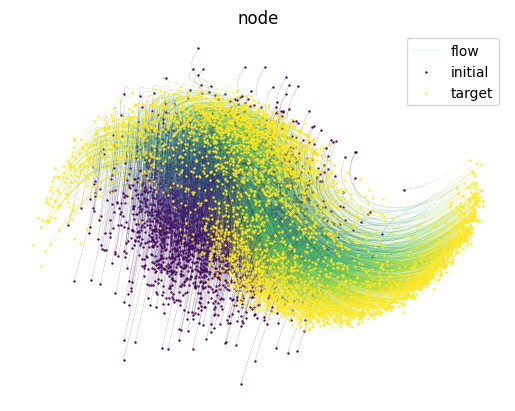

In [173]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
params = {
    'initial': 'normal',
    'target': 'moons',
    'method': 'node',
    'n_batches': 1000,
    'batch_size': 200,
    'odeint_method': 'rk4',
    'lambda_k': .1,
    'lambda_j': .1,
}
target_distr = sampler(params['target'])
initial_distr = sampler(params['initial'])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.train()
model = node(model, optimizer, initial_distr, target_distr, params)
plot(model, params)

Progress: [########################################] 100%, Time: 00:01:33<00:01:33

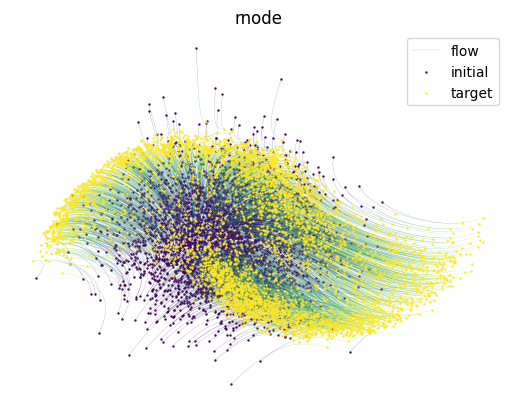

In [174]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
params = {
    'initial': 'normal',
    'target': 'moons',
    'method': 'rnode',
    'n_batches': 1000,
    'batch_size': 200,
    'odeint_method': 'rk4',
    'lambda_k': .1,
    'lambda_j': .1,
}
target_distr = sampler(params['target'])
initial_distr = sampler(params['initial'])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.train()
model = node(model, optimizer, initial_distr, target_distr, params)
plot(model, params)

## Conditional Flow Matching

Another promising approach for learning optimal probability paths is Flow Matching. 
This method offers a simulation-free training objective, which means it eliminates the need to numerically solve an ODE during training. 
Instead of maximizing the likelihood, Flow Matching uses a regression objective to learn a vector field that generates probability paths linking the base and target distributions:
$$\mathbb{E}_{t\sim U([0,1]),\,x} \left [ \|{v_t^\theta(x)-u_t(x)}\|^2 \right ]$$
To make the regression objective tractable, they explicitly construct a conditional probability path and corresponding vector field, such that, when marginalized over the data distribution, it generates the marginal probability path connecting the base and target distributions. 
Furthermore, the conditional probability paths can be chosen as straight Gaussian flows between samples.
However, in general, while the conditional paths are straight, the marginal probability path is nowhere close to the optimal transport path. 
This framework is expanded and generalized by conditioning on samples taken from a joint distribution $\pi$ of the base and target distributions, resulting in the following objective function:
$$\mathbb{E}_{t\sim U([0,1]),\,(x,z)\sim \pi} \left [ \|v_t^\theta(x_t)-(z-x)\|^2 \right ]$$ 
Choosing samples based on the optimal transport plan significantly improves the alignment between the learned transformation and the true optimal transport path. 
This results in more efficient and direct flows, and much faster training in flow-based generative models. 
We refer to this model as Optimal Transport Conditional Flow Matching (OT-CFM). 

In [175]:
#Optimal Transport Sampler
def padding(t, x):
    if isinstance(t, (float, int)):
        return t
    return t.view([x.size(0)] + [1] * (x.dim() - 1))

"""Helper class to sample and compute the OT plan, as well as the conditional location and flow"""
class Conditional_FM():
    def __init__(self, sigma=0):
        self.ot_solver = ot.emd
        self.sigma = sigma
    
    def get_map(self, x0, x1):
        a, b = ot.unif(x0.size(0)), ot.unif(x1.size(0))
        cost = torch.cdist(x0, x1) ** 2
        pi = self.ot_solver(a, b, cost.numpy())

        return pi
    
    def sample_OT(self, x0, x1, batch_size: int):
        pi = self.get_map(x0, x1)
        p = pi.flatten()
        p = p / p.sum()
        choices = np.random.choice(
            pi.shape[0] * pi.shape[1], p=p, size=batch_size)
        i, j = np.divmod(choices, pi.shape[1])
    
        return x0[i], x1[j]  
    
    def sample_location_and_conditional_flow(self, x0, x1):
        t = torch.rand(x0.shape[0]).type_as(x0)
        var = torch.randn_like(x0)
        padded_t = padding(t, x0)
        sigma_t = padding(self.sigma, x0)
        xt = padded_t * x1 + (1 - padded_t) * x0 +  sigma_t * var
        ut = x1 - x0

        return t, xt, ut  

#regression-based method
def cfm(model, optimizer, initial, target, params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    flow_matcher = Conditional_FM()
    start = time.time()
    for i in range(1, params['n_batches']+1):
        optimizer.zero_grad()

        x0, x1 = target(params['batch_size']).to(device), initial(params['batch_size']).to(device)
        if params['method'] == 'ot-cfm':
            x0, x1 = flow_matcher.sample_OT(x0, x1, params['batch_size']) 
        t, xt, ut = flow_matcher.sample_location_and_conditional_flow(x0, x1)
    
        loss = torch.mean((model(t,xt) - ut)**2)
        loss.backward()
        optimizer.step()

        progress_bar(i, params['n_batches'], time.time() - start, ((time.time() - start)/i)*params['n_batches'])

    return model

Progress: [########################################] 100%, Time: 00:00:59<00:00:59

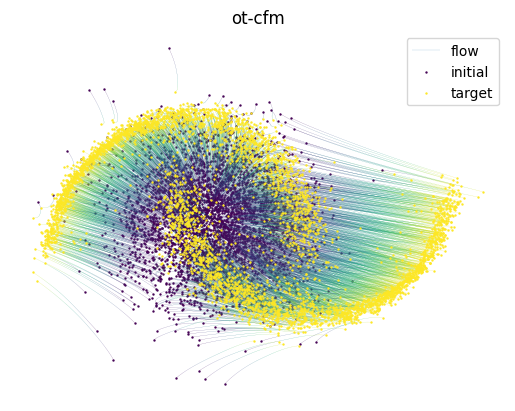

In [176]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
params = {
    'initial': 'normal',
    'target': 'moons',
    'method': 'ot-cfm',
    'n_batches': 10000,
    'batch_size': 200,
    'sigma': 0
}
target_distr = sampler(params['target'])
initial_distr = sampler(params['initial'])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.train()
model = cfm(model, optimizer, initial_distr, target_distr, params)
plot(model, params)

Progress: [########################################] 100%, Time: 00:04:34<00:04:34

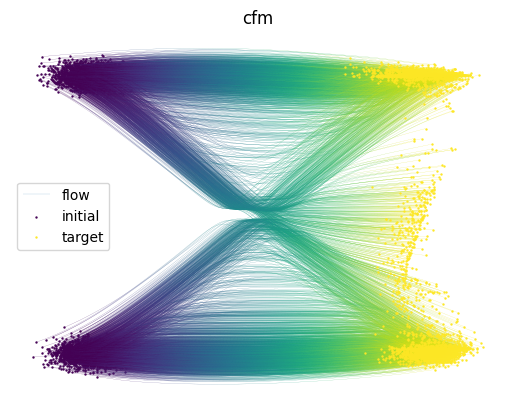

Progress: [########################################] 100%, Time: 00:05:00<00:05:00

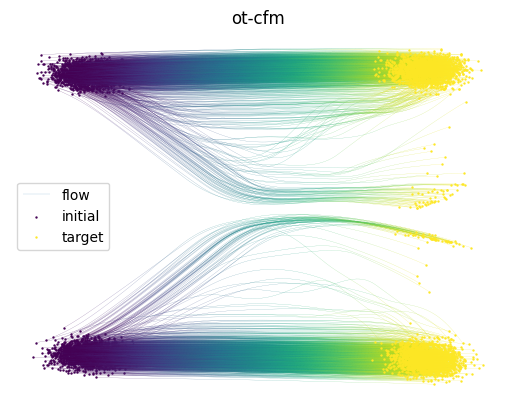

In [177]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
params = {
    'initial': 'mixnormal',
    'target': 'mixnormal',
    'method': 'cfm',
    'n_batches': 5000,
    'batch_size': 200,
    'sigma': 0
}
target_distr = sampler('mixnormal', [torch.tensor((1.000, -1.000)), torch.tensor((1.000,1.000))])
initial_distr = sampler(params['initial'], [torch.tensor((0.000, -1.000)), torch.tensor((0.000,1.000))])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.train()

x = initial_distr(4000)
model1 = cfm(model, optimizer, initial_distr, target_distr, params)
plot(model1, params, x)

params['method'] = 'ot-cfm'
model2 = cfm(model, optimizer, initial_distr, target_distr, params)
plot(model2, params, x)

In [178]:
#function to play around with the different methods
def train(params):
    """ 
    Parameters for Training
        initial: ['moons', 'checkerboard', 'normal']
        target: ['moons', 'checkerboard', 'normal']
        method: ['node', 'rnode', 'cfm', 'ot-cfm]
        n_batches: number of batches for training
        batch_size: size of training batches

    NODE parameters
        odeint_method: ['euler', 'rk4', 'dopri5', 'dopri8']
        lambda_k: regularization constant for the kinetic energy
        lambda_j: regularization constant for the frobenius norm

    CFM parameters
        sigma: variance of gaussian probability paths
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP().to(device)

    target_distr = sampler(params['target'])
    initial_distr = sampler(params['initial'])
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    model.train()

    if params['method'] in ['node', 'rnode']:
        return node(model, optimizer, initial_distr, target_distr, params)
    elif params['method'] in ['cfm', 'ot-cfm']:
        return cfm(model, optimizer, initial_distr, target_distr, params)